In [1]:
%run ../utils/commonImports.py
%run ../utils/tradingImports.py
%matplotlib inline

# Load Data

In [2]:
def calculate_EMA(history, col, time_period):
    return calculateTalib('EMA', {col: history[col].values}, {'timeperiod': time_period})


def add_EMA(df):
    df['blue'] = calculate_EMA(df, 'close', 8)
    df['green'] = calculate_EMA(df, 'close', 13)
    df['yellow'] = calculate_EMA(df, 'close', 21)
    df['red'] = calculate_EMA(df, 'close', 55)
    return df

In [3]:
def load_and_divide(db, table, from_date=None, to_date=None, train_ratio=0.5):
    data = load_trading_data(db, table, from_date, to_date)
    data = add_EMA(data)
    data_train, data_test = divide_train_and_test(data, train_ratio)
    return data, data_train, data_test


db = 'D:\\Dropbox\\My work\\krypl-project\\sqlite\\ploniex-chart-data\\USDT_BTC.db'
data, data_train, data_test = load_and_divide(db, 'chart_data', from_date='2017-01-01')
ohlc, ohlc_train, ohlc_test = data.copy(), data_train.copy(), data_test.copy()


features = ['red', 'yellow', 'green', 'blue']
data_manager_train = CurrencyDataManager(data_train['close'], data_train[features])
data_manager_test = CurrencyDataManager(data_test['close'], data_test[features])
wallet = {'usdt': 1000}
contract_pair = ContractPair.new('usdt', 'btc')

# Explore

In [4]:
correct_pattern = ohlc_train.query("red < yellow < green < blue").copy()

In [ ]:
correct_pattern.shape

In [ ]:
def ratio(df, c1, c2):
    return (df[c1] / df[c2]) - 1


def distplot(df, col, x_max):
    plt.figure(figsize=[12, 6])
    plt.title(col, fontproperties=title_font)
    sns.distplot(df[col])
    plt.xlim([0, x_max])

correct_pattern['ratioRY'] = ratio(correct_pattern, 'yellow', 'red')
correct_pattern['ratioYG'] = ratio(correct_pattern, 'green', 'yellow')
correct_pattern['ratioGB'] = ratio(correct_pattern, 'blue', 'green')

In [ ]:
distplot(correct_pattern, 'ratioRY', 0.015)
distplot(correct_pattern, 'ratioYG', 0.005)
distplot(correct_pattern, 'ratioGB', 0.005)

# Implementation

In [26]:
sum([True, True])

2

In [38]:
from modeling.strategy import Strategy
from itertools import permutations

ORDERS = list(itertools.permutations('BGYR', 4))


class CustomStrategy(Strategy):
    def __init__(self, exchange, data_manager, contract_pair, trade_size, willing_loss, target_profit, params):
        super().__init__(exchange, data_manager, contract_pair, trade_size, willing_loss, target_profit)
        self.history_len = 1
        self.params = params
    
    def has_correct_order(self, _type, red, yellow, green, blue):
        order = self.params['order_' + _type]
        d = {'R': red, 'Y': yellow, 'G': green, 'B': blue}
        l = [d[order[i]] for i in range(len(order))]
        for i in range(len(l)-1):
            if l[i] < l[i+1]:
                return False
        
        thresholds = [self.params[f'r{i}_{_type}'] for i in range(1, len(order))]
        
        def ratio(x, y):
            return (x / y) - 1
        
        for i in range(len(l)-1):
            if ratio(l[i], l[i+1]) > thresholds[i]:
                return False
        
        return True
    
    
    def trade(self):
        after_sell = False
        while self.data_manager.has_tick():            
            history, price = self.data_manager.tick(self.history_len)
            
            if history.shape[0] == 0:
                continue
            
            red, yellow, green, blue = history[0]
            if np.isnan(red):
                continue
            
            if not self.opened and not after_sell and self.has_correct_order('buy', red, yellow, green, blue):
                self.buy(price)
                price_bought = price
            elif self.opened and self.is_risky(price_bought, price):
                self.sell_all(price)
                after_sell = True
            elif self.opened and self.is_target_satisfied(price_bought, price):
                self.sell_all(price)
                after_sell = True
            elif self.opened and self.has_correct_order('sell', red, yellow, green, blue):
                self.sell_all(price)
                after_sell = True
        
        if self.opened:
            self.sell_all(price)


In [79]:
ORDERS

[('B', 'G', 'Y', 'R'),
 ('B', 'G', 'R', 'Y'),
 ('B', 'Y', 'G', 'R'),
 ('B', 'Y', 'R', 'G'),
 ('B', 'R', 'G', 'Y'),
 ('B', 'R', 'Y', 'G'),
 ('G', 'B', 'Y', 'R'),
 ('G', 'B', 'R', 'Y'),
 ('G', 'Y', 'B', 'R'),
 ('G', 'Y', 'R', 'B'),
 ('G', 'R', 'B', 'Y'),
 ('G', 'R', 'Y', 'B'),
 ('Y', 'B', 'G', 'R'),
 ('Y', 'B', 'R', 'G'),
 ('Y', 'G', 'B', 'R'),
 ('Y', 'G', 'R', 'B'),
 ('Y', 'R', 'B', 'G'),
 ('Y', 'R', 'G', 'B'),
 ('R', 'B', 'G', 'Y'),
 ('R', 'B', 'Y', 'G'),
 ('R', 'G', 'B', 'Y'),
 ('R', 'G', 'Y', 'B'),
 ('R', 'Y', 'B', 'G'),
 ('R', 'Y', 'G', 'B')]

In [82]:
def create_strategy(data_manager_p, param_array):
#     params = {
#         'order_buy': ORDERS[int(param_array[0])],
#         'r1_buy': param_array[1],
#         'r2_buy': param_array[2],
#         'r3_buy': param_array[3],
#         'order_sell': ORDERS[int(param_array[4])],
#         'r1_sell': param_array[5],
#         'r2_sell': param_array[6],
#         'r3_sell': param_array[7],
#     }
    
    params = {
        'order_buy': ORDERS[0],
        'r1_buy': param_array[0],
        'r2_buy': param_array[1],
        'r3_buy': param_array[2],
        'order_sell': ORDERS[7],
        'r1_sell': param_array[3],
        'r2_sell': param_array[4],
        'r3_sell': param_array[5],
    }
    
    data_manager = deepcopy(data_manager_p)
    exchange = BackTestExchange(data_manager, deepcopy(wallet), 0.0025)
    strategy = CustomStrategy(exchange, data_manager, contract_pair, 100, willing_loss=0.05, target_profit=1, params=params)
    return data_manager, exchange, strategy

# Learning

In [29]:
def create_train_strategy(param_array):
    return create_strategy(data_manager_train, param_array)

In [40]:
data_manager, exchange, strategy = create_train_strategy([0, 0.005, 0.001, 0.0015, 10, 0.005, 0.001, 0.0015,])
strategy.trade()
r = strategy.stats('usdt').report()
r

,usdt
startAmount,"1,000.0000"
numberOfTrades,1.0000
totalProfit,-5.1266
avgProfit,-5.1266
winPercentage,0.0000
avgWinTrade,0.0000
avgLossTrade,-5.1266
profitFactor,0.0000
maxDrawdown,0.5127


In [88]:
from scipy.optimize import minimize, brute
import sys

def f(x):
    data_manager, exchange, strategy = create_train_strategy(x)
    strategy.trade()
    r = strategy.stats('usdt').report()
    
    sys.stdout.write(f"\r{x}, {r.loc['totalProfit', 'usdt']}")
    sys.stdout.flush()
    return -r.loc['totalProfit', 'usdt']

rranges = [slice(0, 1, 1)] + [slice(0, 1, 0.1)]*3
rranges = rranges + rranges

best_params = minimize(f, [0.001]*6, method="Nelder-Mead")
# best_params = minimize(f, [0.001]*6, method="Powell")


# best_params = brute(f, rranges)
# best_params

[0.001   0.001   0.001   0.001   0.001   0.00105], 28.899170651728127

In [86]:
best_params

   direc: array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])
     fun: -28.899170651728127
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 1
  status: 0
 success: True
       x: array([2.58892896e+00, 5.49148962e-04, 9.54135990e-04, 2.58892896e+00,
       2.58892896e+00, 2.58892896e+00])

In [53]:
data_manager, exchange, strategy = create_train_strategy(best_params['x'])
strategy.trade()
strategy.stats('usdt').report()

,usdt
startAmount,"1,000.0000"
numberOfTrades,0.0000
totalProfit,0.0000
avgProfit,0.0000
winPercentage,0.0000
avgWinTrade,0.0000
avgLossTrade,0.0000
profitFactor,inf
maxDrawdown,0.0000


## Learn Thresholds

In [ ]:
s['totalProfit']

In [ ]:
import timeit


def stats_row(strategy, ry, yg, gb):
    stats = strategy.stats('usdt').report()
    stats = stats.transpose()
    stats['threshold_ry'] = ry
    stats['threshold_yg'] = yg
    stats['threshold_gb'] = gb
    return stats.reset_index().drop('index', axis=1) 

def optimize(rys, ygs, gbs):
    stats = pd.DataFrame()
    for ry in rys:
        for yg in ygs:
            for gb in gbs:
                print('ry = ', ry, 'yg = ', yg, 'gb = ', gb, end='\t')
                start = timeit.timeit()
                data_manager, exchange, strategy = create_train_strategy(ry, yg, gb)
                strategy.trade()
                row_stats = stats_row(strategy, ry, yg, gb)
                stats = stats.append(row_stats)
                profit = row_stats['totalProfit'].iloc[0]
                end = timeit.timeit()
                print('profit = %.2f' % profit,'%.3fs' % (start-end))
    
    return stats.reset_index().drop('index', axis=1)

In [ ]:
stats = optimize([i / 10**4 for i in range(1, 11)], 
         [i / 10**4 for i in range(1, 11)], 
         [i / 10**4 for i in range(1, 11)])
write_tsv(stats, "custom-results.tsv")

In [ ]:
stats.head()

# Look on transactions

In [26]:
len(strategy.exchange.transactions)

270

In [27]:
winningTransactions = []
for i in range(int(len(strategy.exchange.transactions) / 2)):
    t1, t2 = strategy.exchange.transactions[i:i+2]
    if t1['amount'] < t2['amount']:
        winningTransactions += [t1, t2]

In [28]:
len(winningTransactions)

46

In [29]:
strategy.exchange.transactions[2:4]

[{'amount': 0.09642271719217048,
  'fee': 0.25,
  'pair': {'priceContract': 'usdt', 'tradeContract': 'btc'},
  'price': 1037.1,
  'timestamp': 146,
  'type': 'BUY'},
 {'amount': 0.09642271719217048,
  'fee': 0.26202873396731274,
  'pair': {'priceContract': 'usdt', 'tradeContract': 'btc'},
  'price': 1086.99999999,
  'timestamp': 217,
  'type': 'SELL'}]

<IPython.core.display.Javascript object>


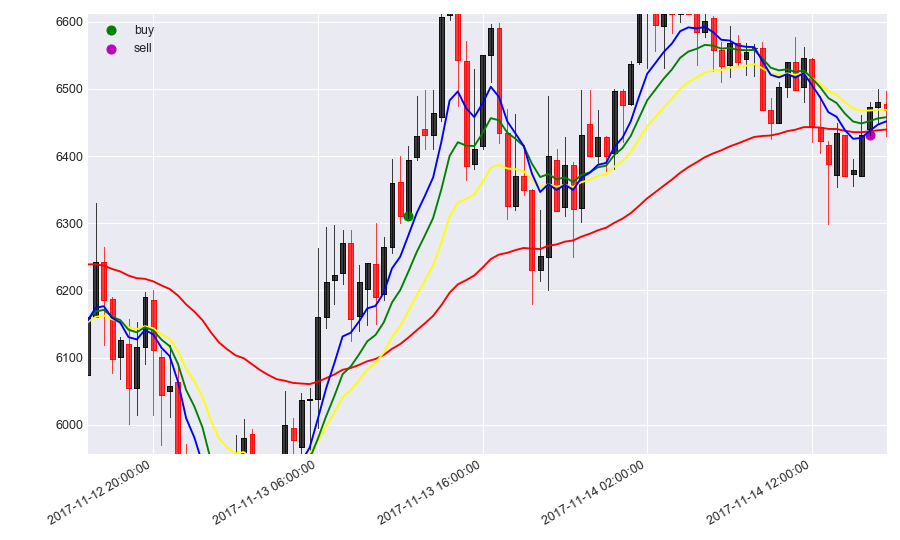

In [30]:
%matplotlib notebook
plot_transactions(ohlc_train, strategy.exchange.transactions[:])

for c in ['red', 'yellow', 'green', 'blue']:
    plt.plot(range(ohlc_train.shape[0]), ohlc_train[c], c=c)

In [ ]:
t = 70

transaction = strategy.exchange.transactions[t]
plotTransactionWithSurroundings(ohlc_train, strategy.historyLen, transaction)
transaction = strategy.exchange.transactions[t+1]
plotTransactionWithSurroundings(ohlc_train, strategy.historyLen, transaction)

In [ ]:
transaction

# Evaluate

In [14]:
def create_test_strategy(threshold_ry, threshold_yg, threshold_gb):
    return create_strategy(data_manager_test, threshold_ry, threshold_yg, threshold_gb)

In [15]:
data_manager, exchange, strategy = create_test_strategy(4.25187625e-06, 2.70615221e-04, 1.12943914e-03)
strategy.trade()
strategy.stats('usdt').report()

,usdt
startAmount,"1,000.0000"
numberOfTrades,64.0000
totalProfit,-56.3810
avgProfit,-0.8810
winPercentage,31.2500
avgWinTrade,3.5675
avgLossTrade,-2.9030
profitFactor,0.5586
maxDrawdown,6.0925
